## No PCA Loss Landscapes

An approach for computing and visualizing 3D loss landscapes for high-dimensional models.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Classifiers

#### Logistic Regression

In [ ]:
class LogisticRegression():
    
    def loss(self, X, y, theta):
        YX = X * y[:,None]
        hy = YX @ theta
        loss = np.log(1+np.exp(-hy)).mean()
        error = (hy <= 0).mean()
        return loss, error
    
    def gradient(self, X, y, theta):
        YX = X * y[:,None]
        m = X.shape[0]
        gradient = -YX.T @ (1/(1+np.exp(YX @ theta)))/m
        return gradient

    def gradient_descent(self, X, y, alpha, iters):
        m,n = X.shape
        theta = np.zeros((iters+1, n))
        loss, err = np.zeros(iters), np.zeros(iters)
        for t in range(iters):
            loss[t], err[t] = self.loss(X, y, theta[t])
            theta[t+1] -= alpha * self.gradient(X, y, theta[t])
        theta = theta[0:iters, :]
        return theta, loss, err

#### SVM

In [ ]:
class SVM():
  
    def loss(self, X, y, theta):
        YX = X * y[:,None]
        hy = YX @ theta
        loss = np.maximum(1-hy,0).mean()
        error = (hy <= 0).mean()
        return loss, error
    
    def gradient(self, X, y, theta):
        YX = X * y[:,None]
        m = X.shape[0]
        gradient = -YX.T @ (YX @ theta <= 1)/m
        return gradient

    def gradient_descent(self, X, y, alpha, iters):
        m,n = X.shape
        theta = np.zeros((iters+1, n))
        loss, err = np.zeros(iters), np.zeros(iters)
        for t in range(iters):
            loss[t], err[t] = self.loss(X, y, theta[t])
            theta[t+1] -= alpha * self.gradient(X, y, theta[t])
        theta = theta[0:iters, :]
        return theta, loss, err

#### Neural Network

In [ ]:
def nn(x, W, b, f):
    """
    Compute output of a neural network.

    Input:
        x: numpy array of input
        W: list of numpy arrays for W parameters
        b: list of numpy arraos for b parameters
        f: list of activation functions for each layer

    Output:
        z: list of activationsn, where each element in the list is a tuple:
           (z_i, z'_i)
           for z_i and z'_i each being a numpy array of activations/derivatives
    """

    z = [(x,)] + [[]]*len(W)
    for i in range(len(W)):
        z[i+1] = (f[i](W[i] @ z[i][0] + b[i])[0],
                  f[i](W[i] @ z[i][0] + b[i])[1])
    return z


In [ ]:
def nn_loss(x, y, W, b, f):
    """
    Compute loss of a neural net prediction, plus gradients of parameters

    Input:
        x: numpy array of input
        y: numpy array of output
        W: list of numpy arrays for W parameters
        b: list of numpy arrays for b parameters
        f: list of activation functions for each layer

    Output tuple: (L, dW, db)
        L: softmax loss on this example
        dW: list of numpy arrays for gradients of W parameters
        db: list of numpy arrays for gradients of b parameters
    """

    z = nn(x,W,b,f)
    L, dL = softmax_loss(z[-1][0], y)
    
    db = [np.zeros(bi.shape) for bi in b]
    dW = [np.zeros(Wi.shape) for Wi in W]
    
    g = dL
    db[-1] = g * z[-1][1]
    dW[-1] = (g * z[-1][1])[:,None] @ z[-2][0][None,:]
    
    for i in range(len(db)-2, -1, -1):
        g = W[i+1].T @ (g * z[i+2][1])
        db[i] = g * z[i+1][1]
        dW[i] = (g * z[i+1][1])[:,None] @ z[i][0][None,:]

    return L, dW, db


In [ ]:
def nn_sgd(X,y, Xt, yt, W, b, f, epochs=10, alpha = 0.01):
    """
    Run stochastic gradient descent to solve linear softmax regression.

    Inputs:
        X: numpy array of training inputs
        y: numpy array of training outputs
        Xt: numpy array of testing inputs
        yt: numpy array of testing outputs
        W: list of W parameters (with initial values)
        b: list of b parameters (with initial values)
        f: list of activation functions
        epochs: number of passes to make over the whole training set
        alpha: step size

    Output: None (you can directly update the W and b inputs in place)
    """
    m = X.shape[0]
    print("{0:10}|{1:10}|{2:10}|{3:10}".\
          format("Test Err", "Train Err", "Test Loss", "Train Loss"))

    # TODO: Modify W and b in-place.
    for i in range(epochs):
        yp = np.vstack([nn(x, W, b, f)[-1][0] for x in X_train])
        ypt = np.vstack([nn(x, W, b, f)[-1][0] for x in X_test])
        print_errors(yp, y, ypt, yt)
        for i in range(m):
            x_i = X_train[i]
            y_i = y_train[i]
            L, dW, db = nn_loss(x_i, y_i, W, b, f)
            for j in range(len(W)):
                b[j] -= alpha * db[j]
                W[j] -= alpha * dW[j]


In [ ]:
np.random.seed(0)
layer_sizes = [784, 200, 100, 10]
W = [0.1*np.random.randn(n,m) for m,n in zip(layer_sizes[:-1], layer_sizes[1:])]
b = [0.1*np.random.randn(n) for n in layer_sizes[1:]]
f = [f_relu]*(len(layer_sizes)-2) + [f_lin]

z = nn(X_train[0], W, b, f)

L, dW, db = nn_loss(X_train[0], y_train[0], W, b, f)

# # nn_sgd should update W and b in-place.
nn_sgd(X_train, y_train, X_test, y_test, W, b, f, epochs=10, alpha=0.01)

### Dataset: Iris

In [7]:
df = pd.read_table('data/iris.data.txt', sep=',', 
                   names=['sepal length', 'sepal width', 'petal length', 'petal width', 'label'])
df = df[df['label'].isin(['Iris-setosa', 'Iris-versicolor'])]   # only keep 2 classes
df = df.reset_index(drop=True)
print('Dimensions:', df.shape)
df.head()

Dimensions: (100, 5)


,sepal length,sepal width,petal length,petal width,label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


#### Train a logistic regression model

In [54]:
X = df.iloc[:,0:4].as_matrix()
y = ((df['label'] == 'Iris-setosa') * 2 - 1).as_matrix()   # convert to 1 / -1 labels
lr_model = LogisticRegression()
theta, loss, err = lr_model.gradient_descent(X, y, 0.1, 10)

In [55]:
print(theta.shape)
theta = theta[-1]   # chose best theta
theta

(10, 4)


array([-0.09191999, -0.02300177, -0.10521241, -0.03668105])

#### Visualize loss landscape

Visualize loss surface by holding all but one parameter constant at their optimal values. Sweep out values of the non-constant parameter around it's optimal value. Evaluate the loss for each combination of parameter values.

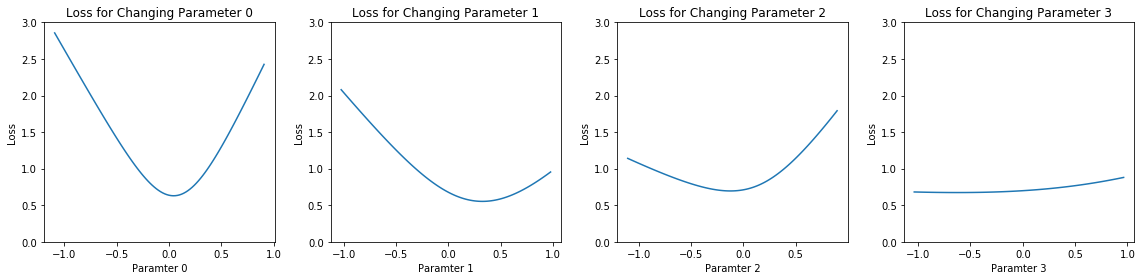

In [69]:
plt.figure(figsize=(16, 4))
for i in range(len(theta)):
    theta_to_change = theta[i]   # the parameter value not held constant
    theta_to_change_sweep = np.linspace(start=(theta_to_change - 1), stop=(theta_to_change + 1), num=100)
    all_theta_values = np.vstack([theta for i in range(100)])   # stack theta values
    all_theta_values[:,i] = theta_to_change_sweep   # insert in non-constant theta values
    loss = [lr_model.loss(X, y, theta_)[0] for theta_ in all_theta_values]
    plt.subplot(1, 4, i+1)
    plt.ylim([0,3])
    plt.plot(theta_to_change_sweep, loss)
    plt.title('Loss for Changing Parameter {}'.format(i))
    plt.ylabel('Loss')
    plt.xlabel('Paramter {}'.format(i))
plt.tight_layout()

Visualize loss surface by holding all but two parameters constant at their optimal values. Sweep out values of the non-constant parameters around their optimal values. Evaluate the loss for each combination of parameter values.

Projecting the theta parameters down to 2 dimensions through PCA.

In [ ]:
theta = (theta - theta.mean(axis=0)) / theta.std(axis=0)   # normalizing theta before PCA

pca = PCA(n_components=2)
theta_reduced = pca.fit_transform(theta)
theta_reduced = pd.DataFrame(theta_reduced, columns=['theta_0', 'theta_1'])

theta_reduced.head()

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(theta_reduced["theta_0"], theta_reduced["theta_1"], lw=0.5)
plt.title("Gradient descent trajectory: PCA dimensions", fontsize=14)
plt.xlabel("PC theta 0", fontsize=13)
plt.ylabel("PC theta 1", fontsize=13)

Creating a dense grid of points centered around the thetas from each iteration of gradient descent. These sampled points will be used for evaluating loss in their regions.

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(theta_reduced["theta_0"], theta_reduced["theta_1"], lw=0.5)

num_samples = 40
offset = 1
min_theta_0, min_theta_1 = theta_reduced["theta_0"].min(), theta_reduced["theta_1"].min()
max_theta_0, max_theta_1 = theta_reduced["theta_0"].max(), theta_reduced["theta_1"].max()
theta_0_range = np.linspace(min_theta_0 - offset, max_theta_0 + offset, num_samples)
theta_1_range = np.linspace(min_theta_1 - offset, max_theta_1 + offset, num_samples)
theta_0_points, theta_1_points = np.meshgrid(theta_0_range, theta_1_range)
plt.plot(theta_0_points, theta_1_points, '.', ms=1, color='k')
plt.title("Theta point grid for PCA dimensions", fontsize=14)
plt.xlabel("PC theta 0", fontsize=13)
plt.ylabel("PC theta 1", fontsize=13)

Create a matrix of the 2D grid of points.

In [ ]:
all_theta_points_2D = []
for theta_0 in theta_0_range:
    for theta_1 in theta_1_range:
        all_theta_points_2D.append([theta_0, theta_1])
all_theta_points_2D = np.array(all_theta_points_2D)
print(all_theta_points_2D.shape)
print(all_theta_points_2D)

Project theta parameters from the 2D points back into their original space.

In [ ]:
all_theta_points_projected = pca.inverse_transform(all_theta_points_2D)
print(all_theta_points_projected.shape)
print(all_theta_points_projected)

Compute loss from projected theta values.

In [ ]:
grid_rows, grid_cols = theta_0_points.shape
loss = np.zeros((grid_rows, grid_cols))
for i in range(grid_rows):
    for j in range(grid_cols):
        theta_ij = all_theta_points_projected[i*grid_rows + j]
        loss[i, j] = lr_model.loss(X, y, theta_ij)[0]
print(loss.shape)
loss

Visualizing the loss landscape with a 3D plot.



In [ ]:
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection='3d')

ax.plot_surface(theta_0_points, theta_1_points, loss, cmap='viridis')
ax.set_title('PCA loss landscape: logistic regression on Iris data',
             fontsize=14)
ax.set_xlabel('PC theta 0', fontsize=13)
ax.set_ylabel('PC theta 1', fontsize=13)
ax.set_zlabel('Loss \n(projected thetas)')
ax.view_init(40, 220)

Saving theta and loss point values

In [ ]:
df = pd.DataFrame({'theta_0': theta_0_points.reshape(num_samples**2),
                   'theta_1': theta_1_points.reshape(num_samples**2),
                   'loss': loss.reshape(num_samples**2)},
                  columns = ['theta_0', 'theta_1', 'loss'])
df.to_csv('data/PCA_loss_LR_iris.csv', index=False)
df.head()

#### Train an SVM model

In [ ]:
svm_model = SVM()
theta, loss, err = svm_model.gradient_descent(X, y, 0.1, 10)

Projecting the theta parameters down to 2 dimensions through PCA.

In [ ]:
theta = (theta - theta.mean(axis=0)) / theta.std(axis=0)   # normalizing theta before PCA

pca = PCA(n_components=2)
theta_reduced = pca.fit_transform(theta)
theta_reduced = pd.DataFrame(theta_reduced, columns=['theta_0', 'theta_1'])

Creating a dense grid of points centered around the thetas from each iteration of gradient descent. These sampled points will be used for evaluating loss in their regions.

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(theta_reduced["theta_0"], theta_reduced["theta_1"], lw=0.5)

num_samples = 40
offset = 1
min_theta_0, min_theta_1 = theta_reduced["theta_0"].min(), theta_reduced["theta_1"].min()
max_theta_0, max_theta_1 = theta_reduced["theta_0"].max(), theta_reduced["theta_1"].max()
theta_0_range = np.linspace(min_theta_0 - offset, max_theta_0 + offset, num_samples)
theta_1_range = np.linspace(min_theta_1 - offset, max_theta_1 + offset, num_samples)
theta_0_points, theta_1_points = np.meshgrid(theta_0_range, theta_1_range)
plt.plot(theta_0_points, theta_1_points, '.', ms=1, color='k')
plt.title("Theta point grid for PCA dimensions", fontsize=14)
plt.xlabel("PC theta 0", fontsize=13)
plt.ylabel("PC theta 1", fontsize=13)

Create a matrix of the 2D grid of points.

In [ ]:
all_theta_points_2D = []
for theta_0 in theta_0_range:
    for theta_1 in theta_1_range:
        all_theta_points_2D.append([theta_0, theta_1])
all_theta_points_2D = np.array(all_theta_points_2D)

Project theta parameters from the 2D points back into their original space.

In [ ]:
all_theta_points_projected = pca.inverse_transform(all_theta_points_2D)

Compute loss from projected theta values.

In [ ]:
grid_rows, grid_cols = theta_0_points.shape
loss = np.zeros((grid_rows, grid_cols))
for i in range(grid_rows):
    for j in range(grid_cols):
        theta_ij = all_theta_points_projected[i*grid_rows + j]
        loss[i, j] = svm_model.loss(X, y, theta_ij)[0]

Visualizing the loss landscape with a 3D plot.



In [ ]:
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection='3d')

ax.plot_surface(theta_0_points, theta_1_points, loss, cmap='viridis')
ax.set_title('PCA loss landscape: SVM on Iris data',
             fontsize=14)
ax.set_xlabel('PC theta 0', fontsize=13)
ax.set_ylabel('PC theta 1', fontsize=13)
ax.set_zlabel('Loss \n(projected thetas)')
ax.view_init(30, 140)

Saving theta and loss point values

In [ ]:
df = pd.DataFrame({'theta_0': theta_0_points.reshape(num_samples**2),
                   'theta_1': theta_1_points.reshape(num_samples**2),
                   'loss': loss.reshape(num_samples**2)},
                  columns = ['theta_0', 'theta_1', 'loss'])
df.to_csv('data/PCA_loss_SVM_iris.csv', index=False)

### Dataset: Breast Cancer

In [ ]:
df = pd.read_csv("data/breast-cancer.csv")
df = df.drop(['id', 'Unnamed: 32'], axis=1)
print('Dimensions:', df.shape)
df.head()


#### Train a logistic regression model

In [ ]:
X = df.iloc[:,1:31].as_matrix()
X = (X - X.mean(axis=0))/X.std(axis=0)
y = ((df['diagnosis'] == 'M') * 2 - 1).as_matrix()   # convert to 1 / -1 labels
lr_model = LogisticRegression()
theta, loss, err = lr_model.gradient_descent(X, y, 0.1, 10)

In [ ]:
print(theta.shape)
theta

Projecting the theta parameters down to 2 dimensions through PCA.

In [ ]:
theta = (theta - theta.mean(axis=0)) / theta.std(axis=0)   # normalizing theta before PCA

pca = PCA(n_components=2)
theta_reduced = pca.fit_transform(theta)
theta_reduced = pd.DataFrame(theta_reduced, columns=['theta_0', 'theta_1'])

theta_reduced.head()

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(theta_reduced["theta_0"], theta_reduced["theta_1"], lw=0.5)
plt.title("Gradient descent trajectory: PCA dimensions", fontsize=14)
plt.xlabel("PC theta 0", fontsize=13)
plt.ylabel("PC theta 1", fontsize=13)

Creating a dense grid of points centered around the thetas from each iteration of gradient descent. These sampled points will be used for evaluating loss in their regions.

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(theta_reduced["theta_0"], theta_reduced["theta_1"], lw=0.5)

num_samples = 40
offset = 1
min_theta_0, min_theta_1 = theta_reduced["theta_0"].min(), theta_reduced["theta_1"].min()
max_theta_0, max_theta_1 = theta_reduced["theta_0"].max(), theta_reduced["theta_1"].max()
theta_0_range = np.linspace(min_theta_0 - offset, max_theta_0 + offset, num_samples)
theta_1_range = np.linspace(min_theta_1 - offset, max_theta_1 + offset, num_samples)
theta_0_points, theta_1_points = np.meshgrid(theta_0_range, theta_1_range)
plt.plot(theta_0_points, theta_1_points, '.', ms=1, color='k')
plt.title("Theta point grid for PCA dimensions", fontsize=14)
plt.xlabel("PC theta 0", fontsize=13)
plt.ylabel("PC theta 1", fontsize=13)

Create a matrix of the 2D grid of points.

In [ ]:
all_theta_points_2D = []
for theta_0 in theta_0_range:
    for theta_1 in theta_1_range:
        all_theta_points_2D.append([theta_0, theta_1])
all_theta_points_2D = np.array(all_theta_points_2D)
print(all_theta_points_2D.shape)
print(all_theta_points_2D)

Project theta parameters from the 2D points back into their original space.

In [ ]:
all_theta_points_projected = pca.inverse_transform(all_theta_points_2D)
print(all_theta_points_projected.shape)
print(all_theta_points_projected)

Compute loss from projected theta values.

In [ ]:
grid_rows, grid_cols = theta_0_points.shape
loss = np.zeros((grid_rows, grid_cols))
for i in range(grid_rows):
    for j in range(grid_cols):
        theta_ij = all_theta_points_projected[i*grid_rows + j]
        loss[i, j] = lr_model.loss(X, y, theta_ij)[0]
print(loss.shape)
loss

Visualizing the loss landscape with a 3D plot.



In [ ]:
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection='3d')

ax.plot_surface(theta_0_points, theta_1_points, loss, cmap='viridis')
ax.set_title('PCA loss landscape: \nlogistic regression on breast cancer data',
             fontsize=14)
ax.set_xlabel('PC theta 0', fontsize=13)
ax.set_ylabel('PC theta 1', fontsize=13)
ax.set_zlabel('Loss \n(projected thetas)')
ax.view_init(20, 200)

Saving theta and loss point values

In [ ]:
df = pd.DataFrame({'theta_0': theta_0_points.reshape(num_samples**2),
                   'theta_1': theta_1_points.reshape(num_samples**2),
                   'loss': loss.reshape(num_samples**2)},
                  columns = ['theta_0', 'theta_1', 'loss'])
df.to_csv('data/PCA_loss_LR_cancer.csv', index=False)
df.head()

#### Train an SVM model

In [ ]:
svm_model = SVM()
theta, loss, err = svm_model.gradient_descent(X, y, 0.1, 10)

Projecting the theta parameters down to 2 dimensions through PCA.

In [ ]:
theta = (theta - theta.mean(axis=0)) / theta.std(axis=0)   # normalizing theta before PCA

pca = PCA(n_components=2)
theta_reduced = pca.fit_transform(theta)
theta_reduced = pd.DataFrame(theta_reduced, columns=['theta_0', 'theta_1'])

Creating a dense grid of points centered around the thetas from each iteration of gradient descent. These sampled points will be used for evaluating loss in their regions.

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(theta_reduced["theta_0"], theta_reduced["theta_1"], lw=0.5)

num_samples = 40
offset = 1
min_theta_0, min_theta_1 = theta_reduced["theta_0"].min(), theta_reduced["theta_1"].min()
max_theta_0, max_theta_1 = theta_reduced["theta_0"].max(), theta_reduced["theta_1"].max()
theta_0_range = np.linspace(min_theta_0 - offset, max_theta_0 + offset, num_samples)
theta_1_range = np.linspace(min_theta_1 - offset, max_theta_1 + offset, num_samples)
theta_0_points, theta_1_points = np.meshgrid(theta_0_range, theta_1_range)
plt.plot(theta_0_points, theta_1_points, '.', ms=1, color='k')
plt.title("Theta point grid for PCA dimensions", fontsize=14)
plt.xlabel("PC theta 0", fontsize=13)
plt.ylabel("PC theta 1", fontsize=13)

Create a matrix of the 2D grid of points.

In [ ]:
all_theta_points_2D = []
for theta_0 in theta_0_range:
    for theta_1 in theta_1_range:
        all_theta_points_2D.append([theta_0, theta_1])
all_theta_points_2D = np.array(all_theta_points_2D)

Project theta parameters from the 2D points back into their original space.

In [ ]:
all_theta_points_projected = pca.inverse_transform(all_theta_points_2D)

Compute loss from projected theta values.

In [ ]:
grid_rows, grid_cols = theta_0_points.shape
loss = np.zeros((grid_rows, grid_cols))
for i in range(grid_rows):
    for j in range(grid_cols):
        theta_ij = all_theta_points_projected[i*grid_rows + j]
        loss[i, j] = svm_model.loss(X, y, theta_ij)[0]

Visualizing the loss landscape with a 3D plot.



In [ ]:
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection='3d')

ax.plot_surface(theta_0_points, theta_1_points, loss, cmap='viridis')
ax.set_title('PCA loss landscape: \nSVM on breast cancer data',
             fontsize=14)
ax.set_xlabel('PC theta 0', fontsize=13)
ax.set_ylabel('PC theta 1', fontsize=13)
ax.set_zlabel('Loss \n(projected thetas)')
ax.view_init(30, 180)

Saving theta and loss point values

In [ ]:
df = pd.DataFrame({'theta_0': theta_0_points.reshape(num_samples**2),
                   'theta_1': theta_1_points.reshape(num_samples**2),
                   'loss': loss.reshape(num_samples**2)},
                  columns = ['theta_0', 'theta_1', 'loss'])
df.to_csv('data/PCA_loss_SVM_cancer.csv', index=False)